In [3]:
"""=============================================================================
   Sở GTCC muốn kiểm tra sự an toàn của các xe nhỏ, hạng trung và cỡ lớn. 
    1. Tạo dataframe như hình vẽ.
    2. Vẽ boxplot, quan sát kết quả.
    3. Áp dụng ANOVA để xem có sự khác biệt đáng kể giữa 3 loại xe (alpha = 5%).
============================================================================="""
import matplotlib.pyplot as plt
import pandas            as pd
import scipy.stats       as stats
import seaborn           as sns
import statsmodels.api   as sm

from statsmodels.formula.api     import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [5]:
#Anova-1way is to compare many samples differing by only one factor (one categorical variable)
# example: compare the height between 54 ethnic groups in Vietnam (the only factor here is ethnic)

#The Anova only let us know if there are significant differences in the group, but not exactly what group
#Therefore, after Anova, we have to conduct post-hoc analysis to define the exact groups where the differences occur

In [9]:
alpha      = .05
confidence = (1 - alpha)

# 1. Tạo dataframe 
df = pd.DataFrame({'S_cars': [643, 655, 702],
                   'M_cars': [469, 427, 525],
                   'X_cars': [484, 456, 402]})

print(df.loc[[0]])

   S_cars  M_cars  X_cars
0     643     469     484


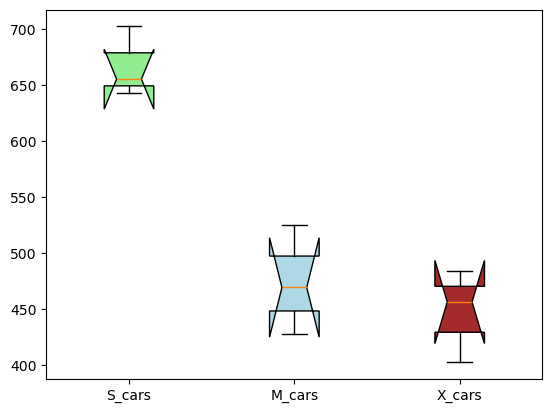

In [32]:
# 2. Vẽ boxplot, quan sát kết quả.
box=plt.boxplot(df, notch=True, tick_labels=list(df.columns), patch_artist=True)

colors=['lightgreen','lightblue','brown']
for patch, color in zip(box['boxes'],colors):
    patch.set_facecolor(color)

plt.show()

In [35]:
# 3. Áp dụng ANOVA
# 3a) Chuẩn bị dữ liệu theo statsmodels
df_melt = pd.melt(df.reset_index(), id_vars = ['index'],      #Create tall dataframe so that the anova function return a result table
                  value_vars = ['S_cars', 'M_cars', 'X_cars'])

# Đổi tên các cột
df_melt.columns = ['index', 'cars', 'value']

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(cars)', data = df_melt).fit()

df_melt

,index,cars,value
0,0,S_cars,643
1,1,S_cars,655
2,2,S_cars,702
3,0,M_cars,469
4,1,M_cars,427
5,2,M_cars,525
6,0,X_cars,484
7,1,X_cars,456
8,2,X_cars,402


In [42]:
# 3b) Kiểm định Levene: S_cars, M_cars, X_cars có cùng phương sai
print('-------------------------------------------------')
print('* Kiểm định LEVENE:                              ')
print('    H0: VAR(S_cars) = VAR(M_cars) = VAR(X_cars)  ')
print('    Ha: Các phương sai KHÔNG BẰNG NHAU           ')
print('-------------------------------------------------')
levene, pvalue = stats.levene(df.S_cars, df.M_cars, df.X_cars)
print('* Levene-statistic = %.4f, p-value = %.4f' % (levene, pvalue))
print('\nP-value > alpha => không bác bỏ H0: VAR(S_cars) = VAR(M_cars) = VAR(X_cars)')
print('Condition of ANOVA-1way is satisfied!')

-------------------------------------------------
* Kiểm định LEVENE:                              
    H0: VAR(S_cars) = VAR(M_cars) = VAR(X_cars)  
    Ha: Các phương sai KHÔNG BẰNG NHAU           
-------------------------------------------------
* Levene-statistic = 0.1767, p-value = 0.8422

P-value > alpha => không bác bỏ H0: VAR(S_cars) = VAR(M_cars) = VAR(X_cars)
Condition of ANOVA-1way is satisfied!


In [47]:
# 3c) Kiểm định Shapiro: S_cars, M_cars, X_cars có pp chuẩn
print('--------------------------------------------------')
print('* Kiểm định SHAPIRO                               ')
print('    H0: S_cars, M_cars, X_cars ~ Norm(Muy, Sigma) ')
print('    Ha: S_cars, M_cars, X_cars KHÔNG pp chuẩn     ')
print('--------------------------------------------------')
shapiro, pvalue = stats.shapiro(model.resid)
print('* Shapiro-statistic = %.4f, p-value = %.4f' % (shapiro, pvalue))
print('\np-value > alpha => không bác bỏ H0: dữ liệu được rút ra từ phân phối chuẩn.')
print('Condition of ANOVA-1way is satisfied!')

--------------------------------------------------
* Kiểm định SHAPIRO                               
    H0: S_cars, M_cars, X_cars ~ Norm(Muy, Sigma) 
    Ha: S_cars, M_cars, X_cars KHÔNG pp chuẩn     
--------------------------------------------------
* Shapiro-statistic = 0.9348, p-value = 0.5284

p-value > alpha => không bác bỏ H0: dữ liệu được rút ra từ phân phối chuẩn.
Condition of ANOVA-1way is satisfied!


In [53]:
# 3d) One-way ANOVA
print('\n* Hàm f_oneway() chỉ trả về F-statistic và p-value; KHÔNG tạo ANOVA table')
fvalue, pvalue = stats.f_oneway(df.S_cars, df.M_cars, df.X_cars)
print('   F-statistic = %.4f, p-value = %.4f' %(fvalue, pvalue))
print('\nGiá trị P-value có ý nghĩa về mặt thống kê (P < 0.05)')
print('do đó, có thể kết luận rằng có sự khác biệt đáng kể giữa các loại xe.')

print('\n* Hàm anova_lm() tạo ANOVA table')
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table, '\n')


* Hàm f_oneway() chỉ trả về F-statistic và p-value; KHÔNG tạo ANOVA table
   F-statistic = 25.1754, p-value = 0.0012

Giá trị P-value có ý nghĩa về mặt thống kê (P < 0.05)
do đó, có thể kết luận rằng có sự khác biệt đáng kể giữa các loại xe.

* Hàm anova_lm() tạo ANOVA table
                sum_sq   df          F    PR(>F)
C(cars)   86049.555556  2.0  25.175411  0.001207
Residual  10254.000000  6.0        NaN       NaN 



In [58]:
# 3e) Kiểm định Tukey HSD
m_comp = pairwise_tukeyhsd(endog = df_melt['value'], groups = df_melt['cars'], alpha = 0.05)
print(m_comp)

print('\nNgoại trừ X_cars và M_cars, tất cả các so sánh cặp khác đều bác bỏ H0')
print('và chỉ ra sự khác biệt đáng kể về mặt thống kê (True là cặp đó có khác biệt).')

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
M_cars S_cars     193.0  0.003   89.4334  296.5666   True
M_cars X_cars  -26.3333 0.7279 -129.8999   77.2332  False
S_cars X_cars -219.3333 0.0015 -322.8999 -115.7668   True
---------------------------------------------------------

Ngoại trừ X_cars và M_cars, tất cả các so sánh cặp khác đều bác bỏ H0
và chỉ ra sự khác biệt đáng kể về mặt thống kê (True là cặp đó có khác biệt).
